In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
from synthetic_utils import *

In [5]:
from trainer_dataloader import *
from networks import *
from losses import *

In [6]:
input_size = 96
batch_size = 128
num_workers = 4
num_epochs = 20

In [7]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))

Device set: cuda


In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
#             transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

In [9]:
DATA_PATH = '/home/var/synthetic_data/gen_shapes/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

In [10]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [11]:
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

## Train only encoder first


In [12]:
encoder = LeNet()
classifier = ClassNet()

In [13]:
criterion = nn.BCELoss()
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_enc = optim.Adam(encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)
scheduler_enc = lr_scheduler.StepLR(optimizer=opt_enc, gamma=0.99, step_size=1)

In [14]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_cls.step()
        scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(train_loader, encoder,
                                classifier, opt_enc,
                                opt_cls, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(val_loader, encoder, classifier,
                                 criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.205 (1.205)	Loss 0.6929 (0.6929)	Accuracy 0.5234 (0.5234)
Batch: [5/40]	Time 0.040 (0.253)	Loss 0.7012 (0.7091)	Accuracy 0.4688 (0.4740)
Batch: [10/40]	Time 0.048 (0.204)	Loss 0.6928 (0.7033)	Accuracy 0.4922 (0.4787)
Batch: [15/40]	Time 0.040 (0.189)	Loss 0.6868 (0.6989)	Accuracy 0.7109 (0.5103)
Batch: [20/40]	Time 0.624 (0.207)	Loss 0.6417 (0.6909)	Accuracy 0.6641 (0.5413)
Batch: [25/40]	Time 0.041 (0.196)	Loss 0.5482 (0.6709)	Accuracy 0.7031 (0.5697)
Batch: [30/40]	Time 0.068 (0.189)	Loss 0.5318 (0.6576)	Accuracy 0.7109 (0.5922)
Batch: [35/40]	Time 0.036 (0.181)	Loss 0.5715 (0.6411)	Accuracy 0.6719 (0.6085)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 0.842 (0.842)	Loss 0.5692 (0.5692)	Accuracy 0.6797 (0.6797)
Avg validation loss: 0.52491224527359 	 Accuracy: 0.726
--------------------
Epoch 0/20	Time 8.081 sec (8.081 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.840 (0.840)	Loss 0.5312 (0.5312)	Accuracy 0.7031 (0.7031)
Batch: [5/40]	Time 0.051 (0.263)	Loss 0.4339 (0.5003)	Accuracy 0.8047 (0.7513)
Batch: [10/40]	Time 0.044 (0.210)	Loss 0.4591 (0.4784)	Accuracy 0.7422 (0.7656)
Batch: [15/40]	Time 0.116 (0.198)	Loss 0.4922 (0.4935)	Accuracy 0.7422 (0.7568)
Batch: [20/40]	Time 0.612 (0.214)	Loss 0.4965 (0.4900)	Accuracy 0.7266 (0.7560)
Batch: [25/40]	Time 0.052 (0.201)	Loss 0.4813 (0.4919)	Accuracy 0.7891 (0.7551)
Batch: [30/40]	Time 0.046 (0.192)	Loss 0.4813 (0.4890)	Accuracy 0.7500 (0.7550)
Batch: [35/40]	Time 0.242 (0.191)	Loss 0.4431 (0.4886)	Accuracy 0.7734 (0.7559)
----------
Test: [0/4]	Time 0.822 (0.822)	Loss 0.4011 (0.4011)	Accuracy 0.8203 (0.8203)
Avg validation loss: 0.48282397890090945 	 Accuracy: 0.75
--------------------
Epoch 1/20	Time 8.196 sec (8.139 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 0.928 (0.928)	Loss 0.4335 (0.4335)	Accuracy 0.7969 (0.7969)
Batch: [5/40]	Time 0.040 (0.289)	Loss 0.4455 

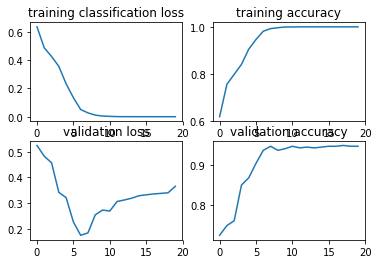

In [15]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

## Train only adversary

In [16]:
from synthetic_dataloader import *
gender_train = GenderDataset(train_df)
gender_valid = GenderDataset(val_df)

In [17]:
advtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
advval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [18]:
adv_encoder = LeNet()
adversary = ClassNet()

In [19]:
adv_criterion = nn.BCELoss()
opt_adv = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_adv_enc = optim.Adam(adv_encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_adv = lr_scheduler.StepLR(optimizer=opt_adv, gamma=0.99, step_size=1)
scheduler_adv_enc = lr_scheduler.StepLR(optimizer=opt_adv_enc, gamma=0.99, step_size=1)

In [20]:
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_adv_enc.step()
        scheduler_adv.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(advtrain_loader,adv_encoder,
                                adversary, opt_adv_enc,
                                opt_adv, adv_criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(advval_loader, adv_encoder, adversary,
                                 adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.877 (0.877)	Loss 0.6957 (0.6957)	Accuracy 0.4844 (0.4844)
Batch: [5/40]	Time 0.056 (0.272)	Loss 0.6506 (0.6873)	Accuracy 0.5000 (0.5456)
Batch: [10/40]	Time 0.048 (0.213)	Loss 0.4259 (0.6124)	Accuracy 0.8516 (0.6456)
Batch: [15/40]	Time 0.036 (0.192)	Loss 0.3991 (0.5358)	Accuracy 0.8359 (0.7109)
Batch: [20/40]	Time 0.522 (0.204)	Loss 0.2089 (0.4736)	Accuracy 0.9531 (0.7560)
Batch: [25/40]	Time 0.036 (0.194)	Loss 0.2572 (0.4188)	Accuracy 0.8984 (0.7897)
Batch: [30/40]	Time 0.046 (0.188)	Loss 0.1439 (0.3779)	Accuracy 0.9453 (0.8133)
Batch: [35/40]	Time 0.096 (0.184)	Loss 0.1988 (0.3619)	Accuracy 0.9062 (0.8279)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 0.862 (0.862)	Loss 0.1166 (0.1166)	Accuracy 0.9844 (0.9844)
Avg validation loss: 0.12134198892116546 	 Accuracy: 0.976
--------------------
Epoch 0/20	Time 8.123 sec (8.123 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.906 (0.906)	Loss 0.1129 (0.1129)	Accuracy 0.9766 (0.9766)
Batch: [5/40]	Time 0.048 (0.285)	Loss 0.1034 (0.1286)	Accuracy 0.9609 (0.9583)
Batch: [10/40]	Time 0.044 (0.221)	Loss 0.0686 (0.1162)	Accuracy 0.9766 (0.9624)
Batch: [15/40]	Time 0.036 (0.201)	Loss 0.0436 (0.1002)	Accuracy 0.9922 (0.9678)
Batch: [20/40]	Time 0.620 (0.216)	Loss 0.0477 (0.0919)	Accuracy 0.9844 (0.9710)
Batch: [25/40]	Time 0.049 (0.206)	Loss 0.0691 (0.0845)	Accuracy 0.9766 (0.9736)
Batch: [30/40]	Time 0.048 (0.196)	Loss 0.0176 (0.0772)	Accuracy 0.9922 (0.9758)
Batch: [35/40]	Time 0.036 (0.190)	Loss 0.0163 (0.0708)	Accuracy 1.0000 (0.9781)
----------
Test: [0/4]	Time 0.864 (0.864)	Loss 0.0140 (0.0140)	Accuracy 0.9922 (0.9922)
Avg validation loss: 0.023877959206700324 	 Accuracy: 0.994
--------------------
Epoch 1/20	Time 8.238 sec (8.180 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 0.916 (0.916)	Loss 0.0180 (0.0180)	Accuracy 0.9922 (0.9922)
Batch: [5/40]	Time 0.049 (0.274)	Loss 0.016

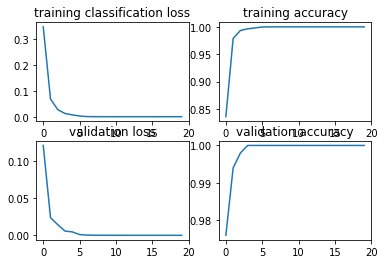

In [21]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

## Train adversary on original encoder

## LAFTR Training

In [22]:
from synthetic_dataloader import *
gender_train = ShapeGenderDataset(train_df)
gender_valid = ShapeGenderDataset(val_df)

In [23]:
laftrtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
laftrval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [24]:
laftr_encoder = LeNet()
laftr_adversary = ClassNet()
laftr_classifier = ClassNet()

In [25]:
laftr_adv_criterion = AdvEqOddsLoss()
laftr_cls_criterion = nn.BCELoss()

In [26]:
laftr_opt_adv = optim.Adam(laftr_adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
laftr_opt_cls = optim.Adam(laftr_classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
laftr_opt_enc = optim.Adam(laftr_encoder.parameters(), lr=0.001, betas=(0.9, 0.999))

laftr_scheduler_adv = lr_scheduler.StepLR(optimizer=laftr_opt_adv, gamma=0.99, step_size=1)
laftr_scheduler_cls = lr_scheduler.StepLR(optimizer=laftr_opt_cls, gamma=0.99, step_size=1)
laftr_scheduler_enc = lr_scheduler.StepLR(optimizer=laftr_opt_enc, gamma=0.99, step_size=1)

In [27]:
num_epochs = 20

clsTrain_losses = []
clsTrain_accs = []
clsTrainCombined_losses = []
advTrain_losses = []
advTrain_accs = []
advTrainCombined_losses = []

combinedVal_losses = []
clsVal_losses = []
clsVal_accs = []
advVal_losses = []
advVal_accs = []

epoch_time = AverageMeter()

In [28]:
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))

        laftr_scheduler_adv.step()
        laftr_scheduler_cls.step()
        laftr_scheduler_enc.step()
        
        cls_loss, cls_en_combinedLoss, cls_en_acc, adv_loss, adv_combinedLoss, adv_acc = laftr_epoch(laftrtrain_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary, laftr_opt_enc,
                                                        laftr_opt_cls, laftr_opt_adv, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        clsTrain_losses.append(cls_loss)
        clsTrain_accs.append(cls_en_acc)
        clsTrainCombined_losses.append(cls_en_combinedLoss)
        advTrain_losses.append(adv_loss)
        advTrain_accs.append(adv_acc)
        advTrainCombined_losses.append(adv_combinedLoss)
        
        print('Classifier accuracy: {}\t Adversary Accuracy: {}'.format(cls_en_acc, adv_acc))
        # validate
        print('-'*10)
        
        combinedVal_loss, clsVal_loss, clsVal_acc, advVal_loss, advVal_acc = laftr_validate(laftrval_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        combinedVal_losses.append(combinedVal_loss)
        clsVal_losses.append(clsVal_loss)
        clsVal_accs.append(clsVal_acc)
        advVal_losses.append(advVal_loss)
        advVal_accs.append(advVal_acc)
        
        print('Classifier validation acc: {:.4f} \t Adv validation acc: {:.4f}'.format(clsVal_acc, advVal_acc))
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.881 (0.881)
Classifier loss 0.6932 (0.6932)	Adversary loss -0.0572 (-0.0572)
Combined Loss during classifier step 0.6934 (0.6934)	Combined Loss during adversary step -0.6266 (-0.6266)
Classifier Accuracy 0.5078 (0.5078)	Adversary Accuracy 0.2188 (0.2188)
Batch: [5/40]	Time 0.100 (0.296)
Classifier loss 0.6987 (0.6944)	Adversary loss -1.1109 (-0.5392)
Combined Loss during classifier step -0.1563 (0.3766)	Combined Loss during adversary step 0.4159 (-0.1409)
Classifier Accuracy 0.5703 (0.5352)	Adversary Accuracy 0.0938 (0.1667)
Batch: [10/40]	Time 0.072 (0.229)
Classifier loss 0.7322 (0.6938)	Adversary loss -1.2871 (-0.8853)
Combined Loss during classifier step -0.4406 (-0.0067)	Combined Loss during adversary step 0.6337 (0.2112)
Classifier Accuracy 0.5625 (0.5369)	Adversary Accuracy 0.1250 (0.1506)
Batch: [15/40]	Time 0.094 (0.216)
Classifier loss 0.8987 (0.7125)	Adversary loss -1.1547 (-1.0291)
Combined Loss during classifier step 0.2202 (-0.1383)	Combined Loss duri

/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test batch: [0/4]	Time 0.823 (0.823)
Classifier loss 0.6232 (0.6232)	Adversary loss -0.0020 (-0.0020)
Combined Loss 0.6213 (0.6213)	Classifier Accuracy 0.6719 (0.6719)	Adversary Accuracy 0.4844 (0.4844)
Classifier validation acc: 0.6720 	 Adv validation acc: 0.4800
--------------------
Epoch 0/20	Time 8.485 sec (8.485 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.929 (0.929)
Classifier loss 0.6425 (0.6425)	Adversary loss -0.0005 (-0.0005)
Combined Loss during classifier step 0.6419 (0.6419)	Combined Loss during adversary step -0.6278 (-0.6278)
Classifier Accuracy 0.6172 (0.6172)	Adversary Accuracy 0.5469 (0.5469)
Batch: [5/40]	Time 0.108 (0.280)
Classifier loss 0.6053 (0.6021)	Adversary loss -0.0056 (-0.0024)
Combined Loss during classifier step 0.6004 (0.6000)	Combined Loss during adversary step -0.5859 (-0.5908)
Classifier Accuracy 0.6797 (0.6576)	Adversary Accuracy 0.4453 (0.4961)
Batch: [10/40]	Time 0.077 (0.237)
Classifier loss 0.6283 (0.5868)	Adversary loss -0.0071 (-0.0038)
Combined Loss during classifier step 0.6214 (0.5833)	Combined Loss during adversary step -0.6215 (-0.5741)
Classifier Accuracy 0.6172 (0.6712)	Adversary Accuracy 0.4922 (0.5050)
Batch: [15/40]	Time 0.070 (0.212)
Classifier loss 0.5670 (0.5729)	Adversary loss -0.0079 (-0.0035)
Combined Loss during classifier step 0.5611 (0.5700)	Combined Loss durin

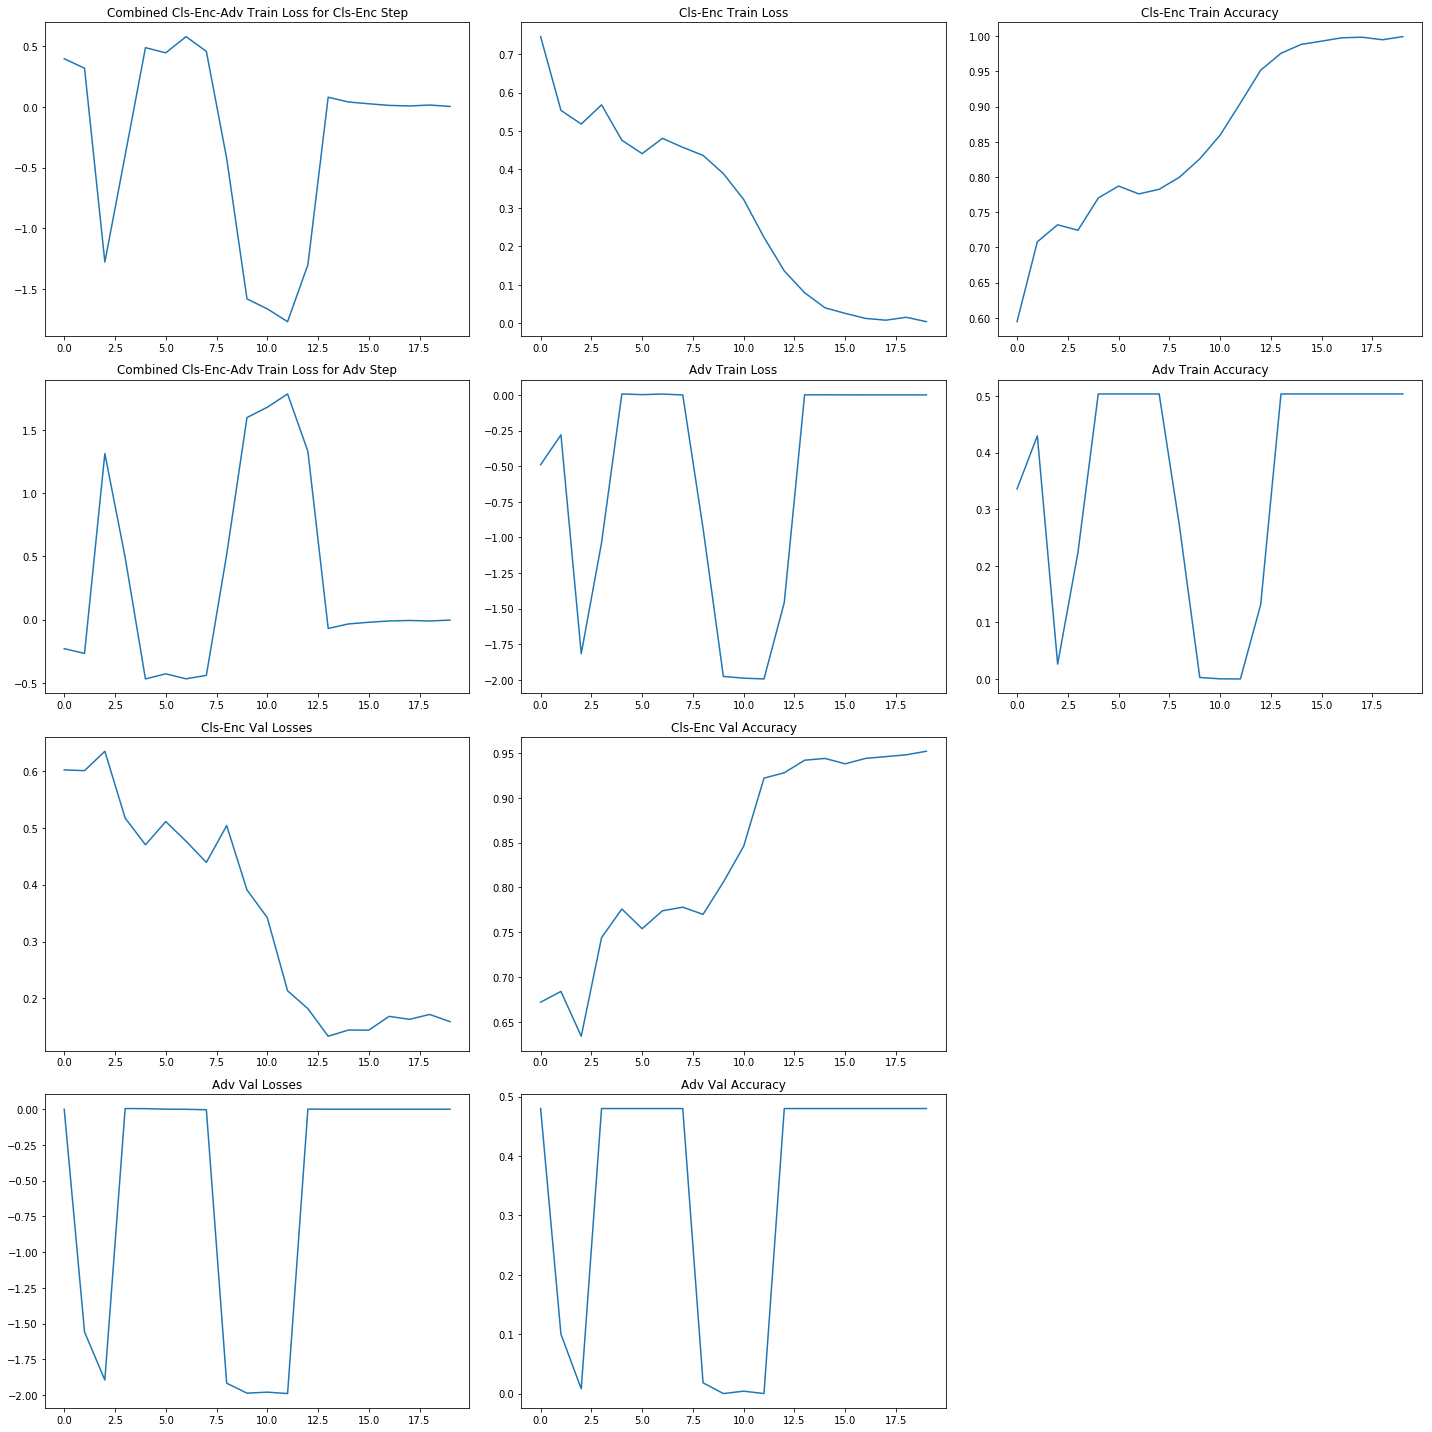

In [29]:
plt.figure(figsize=(20,20))
plt.subplot(431)
plt.title('Combined Cls-Enc-Adv Train Loss for Cls-Enc Step')
plt.plot(clsTrainCombined_losses)
plt.subplot(432)
plt.title('Cls-Enc Train Loss')
plt.plot(clsTrain_losses)
plt.subplot(433)
plt.title('Cls-Enc Train Accuracy')
plt.plot(clsTrain_accs)
plt.subplot(434)
plt.title('Combined Cls-Enc-Adv Train Loss for Adv Step')
plt.plot(advTrainCombined_losses)
plt.subplot(435)
plt.title('Adv Train Loss')
plt.plot(advTrain_losses)
plt.subplot(436)
plt.title('Adv Train Accuracy')
plt.plot(advTrain_accs)

plt.subplot(437)
plt.title('Cls-Enc Val Losses')
plt.plot(clsVal_losses)
plt.subplot(438)
plt.title('Cls-Enc Val Accuracy')
plt.plot(clsVal_accs)
plt.subplot(4,3,10)
plt.title('Adv Val Losses')
plt.plot(advVal_losses)
plt.subplot(4,3,11)
plt.title('Adv Val Accuracy')
plt.plot(advVal_accs)

plt.tight_layout()

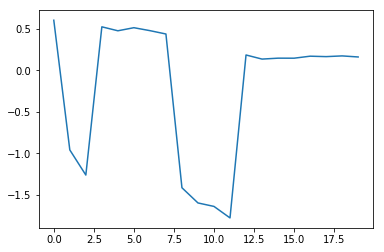

In [30]:
plt.plot(combinedVal_losses)